## Description
---
This notebook is for comparing HYCOM surface temperatures with drifters.

Drifter data can be obtained at:
- https://www.aoml.noaa.gov/phod/gdp/data.php
- Generated URL for download (generated at bottom of download page): http://osmc.noaa.gov/erddap/tabledap/gdp_interpolated_drifter.csv?ID%2CWMO%2Cexpno%2Clongitude%2Clatitude%2Clon360%2Ctime%2Cdeploy_date%2Cdeploy_lat%2Cdeploy_lon%2Cend_date%2Cend_lat%2Cend_lon%2Cdrogue_lost_date%2Ctypedeath%2Ctypebuoy%2Ctemp%2Cve%2Cvn%2Cerr_temp%2Cerr_lat%2Cerr_lon%2CDeployingShip%2CDeploymentStatus%2CBuoyTypeManufacturer%2CBuoyTypeSensorArray%2CCurrentProgram%2CPurchaserFunding%2CSensorUpgrade%2CTransmissions%2CDeployingCountry%2CDeploymentComments%2CManufactureYear%2CManufactureMonth%2CManufactureSensorType%2CManufactureVoltage%2CFloatDiameter%2CSubsfcFloatPresence%2CDrogueType%2CDrogueLength%2CDrogueBallast%2CDragAreaAboveDrogue%2CDragAreaOfDrogue%2CDragAreaRatio%2CDrogueCenterDepth%2CDrogueDetectSensor&longitude%3E=0&longitude%3C=60&latitude%3E=-50&latitude%3C=-10&time%3E=2009-01-01T00%3A00%3A00Z%09&time%3C=2012-03-31T23%3A59%3A59Z&orderBy(%22time%22)

http://osmc.noaa.gov/erddap/tabledap/gdp_interpolated_drifter.csv?ID%2CWMO%2Cexpno%2Clongitude%2Clatitude%2Clon360%2Ctime%2Cdeploy_date%2Cdeploy_lat%2Cdeploy_lon%2Cend_date%2Cend_lat%2Cend_lon%2Cdrogue_lost_date%2Ctypedeath%2Ctypebuoy%2Ctemp%2Cve%2Cvn%2Cerr_temp%2Cerr_lat%2Cerr_lon%2CDeployingShip%2CDeploymentStatus%2CBuoyTypeManufacturer%2CBuoyTypeSensorArray%2CCurrentProgram%2CPurchaserFunding%2CSensorUpgrade%2CTransmissions%2CDeployingCountry%2CDeploymentComments%2CManufactureYear%2CManufactureMonth%2CManufactureSensorType%2CManufactureVoltage%2CFloatDiameter%2CSubsfcFloatPresence%2CDrogueType%2CDrogueLength%2CDrogueBallast%2CDragAreaAboveDrogue%2CDragAreaOfDrogue%2CDragAreaRatio%2CDrogueCenterDepth%2CDrogueDetectSensor&longitude%3E=0&longitude%3C=60&latitude%3E=-10&latitude%3C=-50&time%3E=2009-01-01T00%3A00%3A00Z%09&time%3C=2012-03-31T23%3A59%3A59Z&orderBy(%22time%22)

HYCOM data for comparing to drifters is obtained by:
1. hyc2proj ?

In [1]:
# import glob
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats, spatial
import cmocean.cm as cmo
import cmcrameri.cm as cmc
import seawater
import gsw

In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## First QC drifter data

Turn out that drifter data isn't very well QC'd. Some errors in location of up to 30 degrees and errors in temp up to 30 degrees C. The next cell removes values that are deemed somewhat too high.

In [18]:
# drifters = pd.read_csv('../Data/drifter/gdp_interpolated_drifter_4925_427d_94d7.csv',
#                        usecols = ['ID', 'time (UTC)', 'longitude (degrees_east)',
#                                   'latitude (degrees_north)', 'temp (degree_C)',
#                                   'err_temp (degree_C)'], parse_dates = ['time (UTC)'])

drifters = pd.read_csv('../Data/drifter/gdp_interpolated_drifter_4925_427d_94d7.csv',
                       parse_dates = ['time (UTC)'])

#-----------------------------------------------------------------------------------
# QC Stuff
#-----------------------------------------------------------------------------------
full_len = len(drifters)
print('Original length of records: {0}'.format(full_len))

# Clean data by selecting locational errors less than half a grid size
drifters = drifters[drifters['err_lat (degrees_north)'] <= 0.05]
drifters = drifters[drifters['err_lon (degrees_east)'] <= 0.05]
# Clean data by selecting temp errors less than 0.08 degrees C
drifters = drifters[drifters['err_temp (degree_C)'] <= 0.08]

print('Final length of records: {0}'.format(len(drifters)))
print('Length of records eliminated: {0}'.format(full_len - len(drifters)))
#-----------------------------------------------------------------------------------

# selecting interested columns
drifters = drifters[['ID', 'time (UTC)', 'longitude (degrees_east)',
                                  'latitude (degrees_north)', 'temp (degree_C)',
                                  'err_temp (degree_C)']]

# renaming columns for ease
drifters = drifters.rename(columns={'time (UTC)': 'time',
                                    'longitude (degrees_east)': 'longitude',
                                    'latitude (degrees_north)': 'latitude',
                                    'temp (degree_C)': 'temp',
                                    'err_temp (degree_C)': 'err_temp'})

drifters

/home/harry/miniconda3/envs/ubase/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original length of records: 334790
Final length of records: 277366
Length of records eliminated: 57424


,ID,time,longitude,latitude,temp,err_temp
0,41534,2009-01-01 00:00:00+00:00,52.311,-39.122,14.042,0.042039
1,44647,2009-01-01 00:00:00+00:00,39.393,-23.831,27.543,0.044617
2,54287,2009-01-01 00:00:00+00:00,10.390,-29.191,20.760,0.036442
3,54434,2009-01-01 00:00:00+00:00,38.112,-37.947,18.284,0.044499
4,59346,2009-01-01 00:00:00+00:00,1.388,-33.246,19.595,0.035592
...,...,...,...,...,...,...
334785,92975,2012-03-31 18:00:00+00:00,22.304,-44.270,10.372,0.034828
334786,92986,2012-03-31 18:00:00+00:00,14.316,-41.560,15.489,0.057974
334787,92989,2012-03-31 18:00:00+00:00,9.063,-43.516,9.914,0.037446
334788,98866,2012-03-31 18:00:00+00:00,4.659,-11.805,26.483,0.035935


In [19]:
model = xr.open_dataset('../Data/HYCOM_ostia_Temp_20cm.nc')
# model = model.sel(time = slice('2009-01-01', '2009-01-25'))
# model = model.sel(time = '2009-01-25')
model

<xarray.Dataset>
Dimensions:      (depth: 1, latitude: 444, longitude: 666, time: 1186)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2012-03-31
  * longitude    (longitude) float32 1.0 1.0887218 1.1774436 ... 59.911278 60.0
  * latitude     (latitude) float32 -50.0 -49.93051 ... -10.10637 -10.0
  * depth        (depth) float32 0.2
Data variables:
    mercator     int32 ...
    x            (longitude) float32 ...
    y            (latitude) float32 ...
    model_depth  (latitude, longitude) float32 ...
    temperature  (time, depth, latitude, longitude) float32 ...
Attributes:
    title:          Pilot MyOcean reanalysis by TOPAZ4 (2003-2008)
    institution:    NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    history:        20210601:Created by program hyc2proj, version V0.3
    source:         NERSC-HYCOM model fields
    references:     http://topaz.nersc.no
    field_type:     Files based on file type nersc_daily
    Conventions:    CF-1.4
    field_date:     2009-01-01
    bulletin_date:  2009-01-01

Possibly, the best way to get mean position of drifter to provide location of the mean temp, is by using the package *nvector*: https://github.com/pbrod/nvector

## Strategy
---

The function below can return the following variables and their associated information:
1. `tree`: KDTree object with `.data` providing coordinates of the grid, `.indices` which seem to index each gridcell
2. `dist`: the distance between the drifter and the closest gridcell
3. `idx`: this is the gridcell index that the drifter is closest to. This index should reference `tree.indices` (see point 1, above)

---

#### Reversed steps
1. The final step will be to try return an xarray or some type of 3d array.
2. A vector of differences between grid cells and meaned obs must be sent to array conversion
3. To get a vector of differences, gridcell vector with diffs where available and nans elsewhere must be created.
4. This will first require a vector of same length as the gridcells
5. This vector must then either be filled with nans and then replaced with diffs or filled with diffs and then filled with nans where no diffs exist.
6. To get diffs by gridcell, a mean of all diffs against closest gridcell must be created
7. This could be facilitated by using the idx variable
8. ...

In [8]:
def NearestNeighbourDiff(grid, points, gridInf=1, pointsInf=1):
    ''' The KDTree method used below is outlined at the link below:
       https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
    with some minor modifications in order to produce the differences.
    '''
    
    # Try find lon and lat variables for gridded dataset
    try:
        gridLons = grid['longitude']
    except KeyError:
        try:
            gridLons  = grid['lon']
        except KeyError:
            print("Can't detect gridded dataset longitude dimension.")
            
    try:
        gridLats = grid['latitude']
    except KeyError:
        try:
            gridLats  = grid['lat']
        except KeyError:
            print("Can't detect gridded dataset latitude dimension.")
    
    # Try find lon and lat variables for point observations dataset
    try:
        pointsLons = points['longitude']
    except KeyError:
        try:
            pointsLons  = points['lon']
        except KeyError:
            print("Can't detect point observations longitude dimension.")
            
    try:
        pointsLats = points['latitude']
    except KeyError:
        try:
            pointsLats  = points['lat']
        except KeyError:
            print("Can't detect point observations latitude dimension.")
    
    # Create meshgrid for use with KDTree
    x,y = np.meshgrid(*(gridLons, gridLats))
    
    # Build KDTree from L4 grid
    print('Now building KDTree...')
    tree = spatial.cKDTree(np.column_stack([x.ravel(), y.ravel()]))
    
    # Gather obs coordinates into a numpy column stack
    obs_points = np.column_stack([pointsLons, pointsLats])
    
    # Obtain distances between L2 obs and nearest L4 cell and the index of the L4 cell as
    #   recorded in the KDTree object (tree). Setting upper bound limits distances between
    #   L2 obs and L4 cells and will speed up the operation.
    print('Now querying KDTree for point observations...')
    dist, idx = tree.query(obs_points, distance_upper_bound=0.05, n_jobs=-1)
    print('Tree query completed.')
    
    # Squeeze L4 SSTs and then stack to obtain vector of temperatures to match shape of
    #   L2 observations for easy differencing
    grid_VecData = grid['temperature'].squeeze().stack(vec=['longitude', 'latitude'])
    
    # Obtain the difference between the L2 obs and the nearest L4 cell
    gridPoint_diff = points['temp'] - grid_VecData[idx-1].data
    
    return gridPoint_diff, dist, idx, tree, grid_VecData

In [6]:
modelDrifter_Diff, dist, idx, tree, grid_VecData = NearestNeighbourDiff(model.isel(time=0), drifters)

Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.


In [9]:
dist

array([inf, inf, inf, ..., inf, inf, inf])

In [24]:
grid_VecData[2459].data

array(nan, dtype=float32)

ValueError: not enough values to unpack (expected 2, got 1)

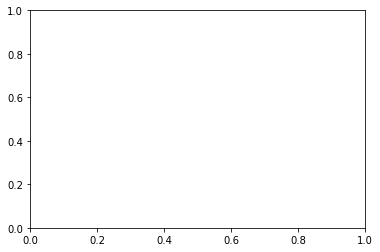

In [12]:
# plt.pcolormesh([grid_VecData['longitude'], grid_VecData['latitude']], grid_VecData.values)
plt.pcolormesh(grid_VecData)

In [38]:
tree.tree

### Selecting drifter data matching date index in model

In [52]:
drifters_sub = drifters.loc[(drifters['time'].dt.date == pd.Timestamp(np.datetime64(model.isel(time=0)['time'].values)))]

In [8]:
modelDrifter_Diff, dist, idx, tree, grid_VecData = NearestNeighbourDiff(model.isel(time=0), drifters_sub)

Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.


In [20]:
# This takes difference between model and drifters and means by gridcell
test = modelDrifter_Diff.to_frame()
test['idx'] = idx
test = test.groupby('idx').mean()
test

,temp
idx,
2,-0.960468
94,-11.309202
102,-14.921977
166,1.489556
179,-10.825659
...,...
2210,NaN
2330,NaN
2388,14.173657


In [48]:
# This creates a nan-array of same length as the grid and replaces values at indices where
# where differences have been calculated
empty_test = np.full_like(grid_VecData, np.nan)
np.put(empty_test, test.index.values, test['temp'].values)
empty_test

array([       nan,        nan, -0.9604679, ...,        nan,        nan,
              nan], dtype=float32)

In [62]:
# This reshapes the vector of meaned model-drifter differences to the model dimensions
empty_test = empty_test.reshape((len(model['latitude']), len(model['longitude'])))

In [64]:
# This makes a copy of the model xr.Dataset and replaces the temperatures with the
# model-drifter differences for the same day.
model_test = model.copy()
model_test = model_test.squeeze()

model_test['temperature'][0] = empty_test
model_test['temperature'][0]

<xarray.DataArray 'temperature' (latitude: 41, longitude: 60)>
array([[       nan,        nan,  -0.960468, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        -10.825659],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2009-01-01
  * longitude  (longitude) float32 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0
  * latitude   (latitude) float32 -50.0 -49.224796 ... -11.176025 -10.0
    depth      float32 0.2
Attributes:
    units:          Celsius
    standard_name:  sea_water_potential_temperature
    grid_mapping:   mercator
    cell_methods:   area: mean

## Re-writing the NearestNeighbourDiff function to output an xarray dataset with same details as the model dataset

In [20]:
def NearestNeighbourDiff(grid, points, gridInf=1, pointsInf=1):
    ''' The KDTree method used below is outlined at the link below:
       https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
    with some minor modifications in order to produce the differences.
    '''
    
    # Make a copy of the model dataset to return an identical dataset of the mean
    # differences between model and drifters
    diff_dataset = grid.copy()
    diff_dataset = diff_dataset.squeeze()
    diff_dataset = diff_dataset.rename_vars({'temperature': 'diff'})
    
    # Try find lon and lat variables for gridded dataset
    try:
        gridLons = grid['longitude']
    except KeyError:
        try:
            gridLons  = grid['lon']
        except KeyError:
            print("Can't detect gridded dataset longitude dimension.")
            
    try:
        gridLats = grid['latitude']
    except KeyError:
        try:
            gridLats  = grid['lat']
        except KeyError:
            print("Can't detect gridded dataset latitude dimension.")
    
    # Try find lon and lat variables for point observations dataset
    try:
        pointsLons = points['longitude']
    except KeyError:
        try:
            pointsLons  = points['lon']
        except KeyError:
            print("Can't detect point observations longitude dimension.")
            
    try:
        pointsLats = points['latitude']
    except KeyError:
        try:
            pointsLats  = points['lat']
        except KeyError:
            print("Can't detect point observations latitude dimension.")
    
    # Create meshgrid for use with KDTree
    x,y = np.meshgrid(*(gridLons, gridLats))
    
    # Build KDTree from L4 grid
    print('Now building KDTree...')
    tree = spatial.cKDTree(np.column_stack([x.ravel(), y.ravel()]))
    
    '''
    Enter loop here.
    
    Loop through 
    '''
    # Loop through each timestep in model
    for timestep in range(len(grid['time'])):
        tstamp = pd.Timestamp(np.datetime64(grid.isel(time=timestep)['time'].values))
        obs_points = drifters.loc[(points['time'].dt.date == tstamp)]
        
        # Gather obs coordinates into a numpy column stack
#         obs_points = np.column_stack([pointsLons, pointsLats])
        obs_locs = np.column_stack([obs_points['longitude'],
                                      obs_points['latitude']])
    
        # Obtain distances between L2 obs and nearest L4 cell and the index of the L4
        # cell as recorded in the KDTree object (tree). Setting upper bound limits
        # distances between L2 obs and L4 cells and will speed up the operation.
        dist, idx = tree.query(obs_locs, distance_upper_bound=0.05, n_jobs=-1)
        print('Tree query completed for {0}.'.format(tstamp))
    
        # Squeeze L4 SSTs and then stack to obtain vector of temperatures to match
        # shape of L2 observations for easy differencing
        grid_VecData = grid['temperature'][timestep].squeeze().stack(vec=['latitude',
                                                                          'longitude'])
    
        # Obtain the difference between the L2 obs and the nearest L4 cell
#         gridPoint_diff = obs_points['temp'] - grid_VecData[idx-1].data
        gridPoint_diff = grid_VecData[idx-1].data - obs_points['temp']
        
        # This takes difference between model and drifters and means by gridcell
        gridPoint_diff = gridPoint_diff.to_frame()
        gridPoint_diff['idx'] = idx
        gridPoint_diff = gridPoint_diff.groupby('idx').mean()
        
        # This creates a nan-array of same length as the grid and replaces values
        # at indices where where differences have been calculated
        modGrid_diff = np.full_like(grid_VecData, np.nan)
        np.put(modGrid_diff, gridPoint_diff.index.values-1, gridPoint_diff['temp'].values)
        
        # This reshapes the vector of meaned model-drifter differences to the
        # model dimensions
        modGrid_diff = modGrid_diff.reshape((len(model['latitude']),
                                             len(model['longitude'])))
        
        # This makes a copy of the model xr.Dataset and replaces the temperatures
        # with the model-drifter differences for the same day.
        diff_dataset['diff'][timestep] = modGrid_diff
    
    return diff_dataset

In [21]:
test = NearestNeighbourDiff(model, drifters)
# obs_points2 = NearestNeighbourDiff(model, drifters)

Now building KDTree...
Tree query completed for 2009-01-01 00:00:00.
Tree query completed for 2009-01-02 00:00:00.
Tree query completed for 2009-01-03 00:00:00.
Tree query completed for 2009-01-04 00:00:00.
Tree query completed for 2009-01-05 00:00:00.
Tree query completed for 2009-01-06 00:00:00.
Tree query completed for 2009-01-07 00:00:00.
Tree query completed for 2009-01-08 00:00:00.
Tree query completed for 2009-01-09 00:00:00.
Tree query completed for 2009-01-10 00:00:00.
Tree query completed for 2009-01-11 00:00:00.
Tree query completed for 2009-01-12 00:00:00.
Tree query completed for 2009-01-13 00:00:00.
Tree query completed for 2009-01-14 00:00:00.
Tree query completed for 2009-01-15 00:00:00.
Tree query completed for 2009-01-16 00:00:00.
Tree query completed for 2009-01-17 00:00:00.
Tree query completed for 2009-01-18 00:00:00.
Tree query completed for 2009-01-19 00:00:00.
Tree query completed for 2009-01-20 00:00:00.
Tree query completed for 2009-01-21 00:00:00.
Tree query 

Tree query completed for 2009-06-29 00:00:00.
Tree query completed for 2009-06-30 00:00:00.
Tree query completed for 2009-07-01 00:00:00.
Tree query completed for 2009-07-02 00:00:00.
Tree query completed for 2009-07-03 00:00:00.
Tree query completed for 2009-07-04 00:00:00.
Tree query completed for 2009-07-05 00:00:00.
Tree query completed for 2009-07-06 00:00:00.
Tree query completed for 2009-07-07 00:00:00.
Tree query completed for 2009-07-08 00:00:00.
Tree query completed for 2009-07-09 00:00:00.
Tree query completed for 2009-07-10 00:00:00.
Tree query completed for 2009-07-11 00:00:00.
Tree query completed for 2009-07-12 00:00:00.
Tree query completed for 2009-07-13 00:00:00.
Tree query completed for 2009-07-14 00:00:00.
Tree query completed for 2009-07-15 00:00:00.
Tree query completed for 2009-07-16 00:00:00.
Tree query completed for 2009-07-17 00:00:00.
Tree query completed for 2009-07-18 00:00:00.
Tree query completed for 2009-07-19 00:00:00.
Tree query completed for 2009-07-2

Tree query completed for 2009-12-26 00:00:00.
Tree query completed for 2009-12-27 00:00:00.
Tree query completed for 2009-12-28 00:00:00.
Tree query completed for 2009-12-29 00:00:00.
Tree query completed for 2009-12-30 00:00:00.
Tree query completed for 2009-12-31 00:00:00.
Tree query completed for 2010-01-01 00:00:00.
Tree query completed for 2010-01-02 00:00:00.
Tree query completed for 2010-01-03 00:00:00.
Tree query completed for 2010-01-04 00:00:00.
Tree query completed for 2010-01-05 00:00:00.
Tree query completed for 2010-01-06 00:00:00.
Tree query completed for 2010-01-07 00:00:00.
Tree query completed for 2010-01-08 00:00:00.
Tree query completed for 2010-01-09 00:00:00.
Tree query completed for 2010-01-10 00:00:00.
Tree query completed for 2010-01-11 00:00:00.
Tree query completed for 2010-01-12 00:00:00.
Tree query completed for 2010-01-13 00:00:00.
Tree query completed for 2010-01-14 00:00:00.
Tree query completed for 2010-01-15 00:00:00.
Tree query completed for 2010-01-1

Tree query completed for 2010-06-24 00:00:00.
Tree query completed for 2010-06-25 00:00:00.
Tree query completed for 2010-06-26 00:00:00.
Tree query completed for 2010-06-27 00:00:00.
Tree query completed for 2010-06-28 00:00:00.
Tree query completed for 2010-06-29 00:00:00.
Tree query completed for 2010-06-30 00:00:00.
Tree query completed for 2010-07-01 00:00:00.
Tree query completed for 2010-07-02 00:00:00.
Tree query completed for 2010-07-03 00:00:00.
Tree query completed for 2010-07-04 00:00:00.
Tree query completed for 2010-07-05 00:00:00.
Tree query completed for 2010-07-06 00:00:00.
Tree query completed for 2010-07-07 00:00:00.
Tree query completed for 2010-07-08 00:00:00.
Tree query completed for 2010-07-09 00:00:00.
Tree query completed for 2010-07-10 00:00:00.
Tree query completed for 2010-07-11 00:00:00.
Tree query completed for 2010-07-12 00:00:00.
Tree query completed for 2010-07-13 00:00:00.
Tree query completed for 2010-07-14 00:00:00.
Tree query completed for 2010-07-1

Tree query completed for 2010-12-21 00:00:00.
Tree query completed for 2010-12-22 00:00:00.
Tree query completed for 2010-12-23 00:00:00.
Tree query completed for 2010-12-24 00:00:00.
Tree query completed for 2010-12-25 00:00:00.
Tree query completed for 2010-12-26 00:00:00.
Tree query completed for 2010-12-27 00:00:00.
Tree query completed for 2010-12-28 00:00:00.
Tree query completed for 2010-12-29 00:00:00.
Tree query completed for 2010-12-30 00:00:00.
Tree query completed for 2010-12-31 00:00:00.
Tree query completed for 2011-01-01 00:00:00.
Tree query completed for 2011-01-02 00:00:00.
Tree query completed for 2011-01-03 00:00:00.
Tree query completed for 2011-01-04 00:00:00.
Tree query completed for 2011-01-05 00:00:00.
Tree query completed for 2011-01-06 00:00:00.
Tree query completed for 2011-01-07 00:00:00.
Tree query completed for 2011-01-08 00:00:00.
Tree query completed for 2011-01-09 00:00:00.
Tree query completed for 2011-01-10 00:00:00.
Tree query completed for 2011-01-1

Tree query completed for 2011-06-19 00:00:00.
Tree query completed for 2011-06-20 00:00:00.
Tree query completed for 2011-06-21 00:00:00.
Tree query completed for 2011-06-22 00:00:00.
Tree query completed for 2011-06-23 00:00:00.
Tree query completed for 2011-06-24 00:00:00.
Tree query completed for 2011-06-25 00:00:00.
Tree query completed for 2011-06-26 00:00:00.
Tree query completed for 2011-06-27 00:00:00.
Tree query completed for 2011-06-28 00:00:00.
Tree query completed for 2011-06-29 00:00:00.
Tree query completed for 2011-06-30 00:00:00.
Tree query completed for 2011-07-01 00:00:00.
Tree query completed for 2011-07-02 00:00:00.
Tree query completed for 2011-07-03 00:00:00.
Tree query completed for 2011-07-04 00:00:00.
Tree query completed for 2011-07-05 00:00:00.
Tree query completed for 2011-07-06 00:00:00.
Tree query completed for 2011-07-07 00:00:00.
Tree query completed for 2011-07-08 00:00:00.
Tree query completed for 2011-07-09 00:00:00.
Tree query completed for 2011-07-1

Tree query completed for 2011-12-16 00:00:00.
Tree query completed for 2011-12-17 00:00:00.
Tree query completed for 2011-12-18 00:00:00.
Tree query completed for 2011-12-19 00:00:00.
Tree query completed for 2011-12-20 00:00:00.
Tree query completed for 2011-12-21 00:00:00.
Tree query completed for 2011-12-22 00:00:00.
Tree query completed for 2011-12-23 00:00:00.
Tree query completed for 2011-12-24 00:00:00.
Tree query completed for 2011-12-25 00:00:00.
Tree query completed for 2011-12-26 00:00:00.
Tree query completed for 2011-12-27 00:00:00.
Tree query completed for 2011-12-28 00:00:00.
Tree query completed for 2011-12-29 00:00:00.
Tree query completed for 2011-12-30 00:00:00.
Tree query completed for 2011-12-31 00:00:00.
Tree query completed for 2012-01-01 00:00:00.
Tree query completed for 2012-01-02 00:00:00.
Tree query completed for 2012-01-03 00:00:00.
Tree query completed for 2012-01-04 00:00:00.
Tree query completed for 2012-01-05 00:00:00.
Tree query completed for 2012-01-0

In [72]:
obs_points

,ID,longitude,latitude,time,temp,err_temp
0,41534,52.311,-39.122,2009-01-01 00:00:00+00:00,14.042,0.042039
1,44647,39.393,-23.831,2009-01-01 00:00:00+00:00,27.543,0.044617
2,54287,10.390,-29.191,2009-01-01 00:00:00+00:00,20.760,0.036442
3,54434,38.112,-37.947,2009-01-01 00:00:00+00:00,18.284,0.044499
4,59346,1.388,-33.246,2009-01-01 00:00:00+00:00,19.595,0.035592
...,...,...,...,...,...,...
290,54265,59.746,-31.330,2009-01-01 18:00:00+00:00,22.604,0.039558
291,54307,1.787,-21.418,2009-01-01 18:00:00+00:00,21.850,0.037190
292,54624,3.467,-20.614,2009-01-01 18:00:00+00:00,21.979,0.045651
293,57903,26.034,-39.808,2009-01-01 18:00:00+00:00,16.195,0.036542


In [86]:
obs_points2

array([[ 52.311, -39.122],
       [ 39.393, -23.831],
       [ 10.39 , -29.191],
       [ 38.112, -37.947],
       [  1.388, -33.246],
       [ 33.289, -36.654],
       [ 40.373, -36.27 ],
       [ 24.554, -37.622],
       [ 49.632, -40.051],
       [ 56.502, -39.347],
       [ 21.989, -40.85 ],
       [ 42.329, -10.096],
       [ 53.782, -10.549],
       [ 48.158, -30.13 ],
       [ 58.138, -41.847],
       [ 52.272, -19.551],
       [ 54.407, -27.87 ],
       [ 51.304, -15.097],
       [ 51.2  , -12.596],
       [ 55.389, -17.699],
       [ 50.485, -31.593],
       [ 47.032, -48.642],
       [ 25.754, -39.604],
       [ 44.891, -46.241],
       [ 39.329, -47.743],
       [ 49.062, -11.302],
       [ 34.281, -28.771],
       [ 47.995, -24.535],
       [ 42.913, -21.044],
       [  6.633, -44.928],
       [ 42.683, -49.162],
       [  6.532, -37.619],
       [ 50.307, -45.353],
       [ 34.125, -39.867],
       [ 56.419, -47.262],
       [ 36.635, -46.581],
       [ 11.83 , -35.38 ],
 

In [63]:
test['diff']

<xarray.DataArray 'diff' (time: 25, latitude: 444, longitude: 666)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-01-25
  * longitude  (longitude) float32 1.0 1.0887218 1.1774436 ... 59.911278 60.0
  * latitude   (latitude) float32 -50.0 -49.93051 -49.86092 ... -10.10637 -10.0
    depth      float32 0.2
Attributes:
    units:          Celsius
    standard_name:  sea_water_potential_temperature
    grid_mapping:   mercator
    cell_methods:   area: mean

/home/harry/miniconda3/envs/ubase/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Mean: 0.16700418293476105 +- 1.1038364171981812


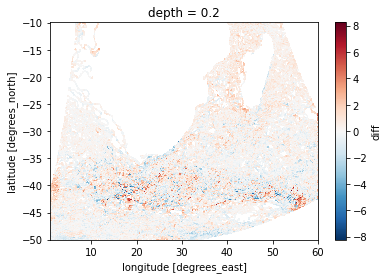

In [22]:
test['diff'].mean(dim='time').plot()
print('Mean: {0} +- {1}'.format(np.nanmean(test['diff']), np.nanstd(test['diff'])))
# plt.pcolormesh([test['longitude'], test['latitude']], test['diff'].mean())

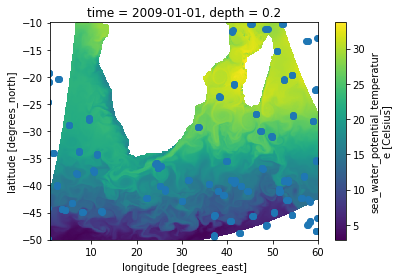

In [101]:
fig, ax = plt.subplots(1,1)

img = model['temperature'][0,0,:,:].plot(ax=ax)
ax.scatter(drifters_sub['longitude'], drifters_sub['latitude'])

In [23]:
model['temperature'][0,0,:,:]

<xarray.DataArray 'temperature' (latitude: 41, longitude: 60)>
array([[     nan,      nan, 3.412477, ...,      nan,      nan,      nan],
       [4.395218, 4.650002, 3.925282, ...,      nan,      nan,      nan],
       [4.63059 , 4.875668, 5.210527, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2009-01-01
  * longitude  (longitude) float32 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0
  * latitude   (latitude) float32 -50.0 -49.224796 ... -11.176025 -10.0
    depth      float32 0.2
Attributes:
    units:          Celsius
    standard_name:  sea_water_potential_temperature
    grid_mapping:   mercator
    cell_methods:   area: mean